In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Read main data to DataFrame
df = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

# Income variables

In [4]:
df1=df[["hogarid_old","cp_old","unique_05","s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05",
        "s1hhsz_15_24_05","s1hhsz_25_64_05","s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05",
        "s3ap23_stime_h_05","s3ap24_htime_h_05","s3ap25_hqtime_h_05","s3atoilet_hh_05","s3awater_access_hh_05",
        "s3aelectric_hh_05","s4p6_vitamina_i_05","s4p7_parasite_i_05","s11ownland_hh_05","cons_food_pc_05","cons_tot_pc_05",
        "tvip_05","height_05","a10whz_05","weight_05","itt_i","itt_all_i","yrsedfath","age_transfer","bweight",
        "s4p7_parasite_i_06","cpmom_06","T","male","TREAT1","TREAT2","TREAT3","TREAT4","ed_mom","MUN1","MUN2","MUN3","MUN4",
        "MUN5","MUN6","com_haz_05","com_waz_05","com_tvip_05","com_control_05","com_vit_05","com_deworm_05","com_notvip",
        "sample06","vitamiron_06",#"weighted_05",
        "propfood_05","prstap_f_05","pranimalprot_f_05","prfruitveg_f_05"]]

In [5]:
df1.rename(columns = {'T':'tr'}, inplace = True)

C:\Users\Usuari\AppData\Local\Temp\ipykernel_11752\2300806653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns = {'T':'tr'}, inplace = True)


In [6]:
#fem una copia del df
def copy_df(df):
   return df.copy()

In [7]:
#eliminem individus amb >delta*100% columnes buides
def drop_ind_missing(df, delta):
    thresh = len(df.columns)*delta
    df.dropna(axis=0, thresh=thresh, inplace=True)
    return df

In [8]:
#eliminem individus amb age transfer<age
def drop_out_missing(df, age=-11):
    nan_rows=df[df.age_transfer<age].index
    df.drop(nan_rows, inplace=True)
    return df

In [9]:
#categorical to ordinal
def ordinal(df, cols):
    enc = OrdinalEncoder()
    enc.fit(df[cols])
    df[cols] = enc.transform(df[cols])
    
    return df

In [10]:
#imputem NaNs

#imputem mitjanes
def mean_imputer(df, cols):
    for col in cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

#imputem el valor més frequent de la columna dintre el hh
def hh_mf_imputer(df,cols):
    index=df.index
    for col in cols:
        col_hh=[df[df.hogarid_old==familia][[col,"age_transfer"]].sort_values(by=['age_transfer'])[col]
                .values for familia in df.hogarid_old]
        for i in range(len(index)):
               if np.isnan(df[col][index[i]]):
                    non_nan_len=np.count_nonzero(~np.isnan(col_hh[i]))
                    if(non_nan_len!=0):
                        vals,counts = np.unique(col_hh[i], return_counts=True)
                        ind = np.argmax(counts)
                        df.loc[index[i],col]=vals[ind]
    return df             
                            
                        

In [11]:
#eliminem outliers

def outlier_removal(df,cols):
    outlier_threshold = []
    for col in cols:
            q3 = np.nanpercentile(df[col], 75)
            q1 = np.nanpercentile(df[col], 25)
            iqr = q3 - q1
            out_low = q1 - 1.5*iqr
            out_high = q3 + 1.5*iqr
            outlier_threshold.append([out_low, out_high])
    outliers_indexs=[]
    for col,k in zip(cols,range(len(cols))):
        #outliers_indexs_in_col=[]
        for i in range(len(df[col])):
            if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
                outliers_indexs.append(i)
        #outliers_indexs.append(outliers_indexs_in_col)
    print(len(list(set(outliers_indexs))))
    return df.drop(list(set(outliers_indexs)), axis=0)

In [12]:
def normalize(df, cols):
    Nscaler = MinMaxScaler()

    Nscaler.fit(df[cols])
    df[cols] = Nscaler.transform(df[cols])
    
    return df

def standardize(df, cols):
    Sscaler = StandardScaler()

    Sscaler.fit(df[cols])
    df[cols] = Sscaler.transform(df[cols])
    
    return df

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mean_cols=["bweight", "tvip_05", "height_05", "a10whz_05", "weight_05"]
hh_mf_cols=["s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05","s1hhsz_15_24_05","s1hhsz_25_64_05",
            "s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05","s3atoilet_hh_05",
            "s3awater_access_hh_05","s3aelectric_hh_05","s11ownland_hh_05","s4p7_parasite_i_06","ed_mom","vitamiron_06",
           "s4p6_vitamina_i_05", "s4p7_parasite_i_05", "cons_food_pc_05", "yrsedfath", "propfood_05", "prstap_f_05"
            ,  "pranimalprot_f_05",  "prfruitveg_f_05"]

normal_cols =["height_05","a10whz_05","weight_05","com_haz_05","com_waz_05"]

Nnormal_cols = ['s1age_head_05', 's3ap23_stime_h_05', 's3ap24_htime_h_05', 's3ap25_hqtime_h_05', 'cons_food_pc_05', 
                'cons_tot_pc_05', 'tvip_05', 'yrsedfath','age_transfer', 'bweight', 'ed_mom', 'com_tvip_05', 'com_control_05']

categorical_cols=df1.select_dtypes(exclude=["number","bool_","object_"]).columns

cleaned_df=(df1.pipe(copy_df)
            .pipe(drop_ind_missing, 0.8)
            .pipe(drop_out_missing)
            .pipe(ordinal, categorical_cols)
            .pipe(hh_mf_imputer, hh_mf_cols)
            .pipe(mean_imputer, mean_cols+hh_mf_cols))
            #.pipe(outlier_removal)) #outliers
            #.pipe(standardize, normal_cols) #estandaritzacio
            #.pipe(normalize, Nnormal_cols)) #normalitzacio
                         

In [17]:
prova=(df1.pipe(copy_df)
            .pipe(drop_ind_missing, 0.8)
            .pipe(drop_out_missing)
            .pipe(ordinal, categorical_cols))
df=prova
outlier_threshold = []
cols=df.columns
for col in cols:
    q3 = np.nanpercentile(df[col], 75)
    q1 = np.nanpercentile(df[col], 25)
    iqr = q3 - q1
    out_low = q1 - 3*iqr
    out_high = q3 + 3*iqr
    outlier_threshold.append([out_low, out_high])
outliers_indexs=[]

series_values=[]
for col,k in zip(cols,range(len(cols))):
    outliers_indexs_in_col=[]
    for i in df[col].index:
        if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
            outliers_indexs.append(i)
            outliers_indexs_in_col.append(i)
    #outliers_indexs.append(outliers_indexs_in_col)
    series_values.append(len(outliers_indexs_in_col))

outliers=pd.Series(series_values,index=df.columns)

In [28]:
outliers=outliers[outliers!=[0]*len(outliers)].sort_values()

In [31]:
len (outliers)

33

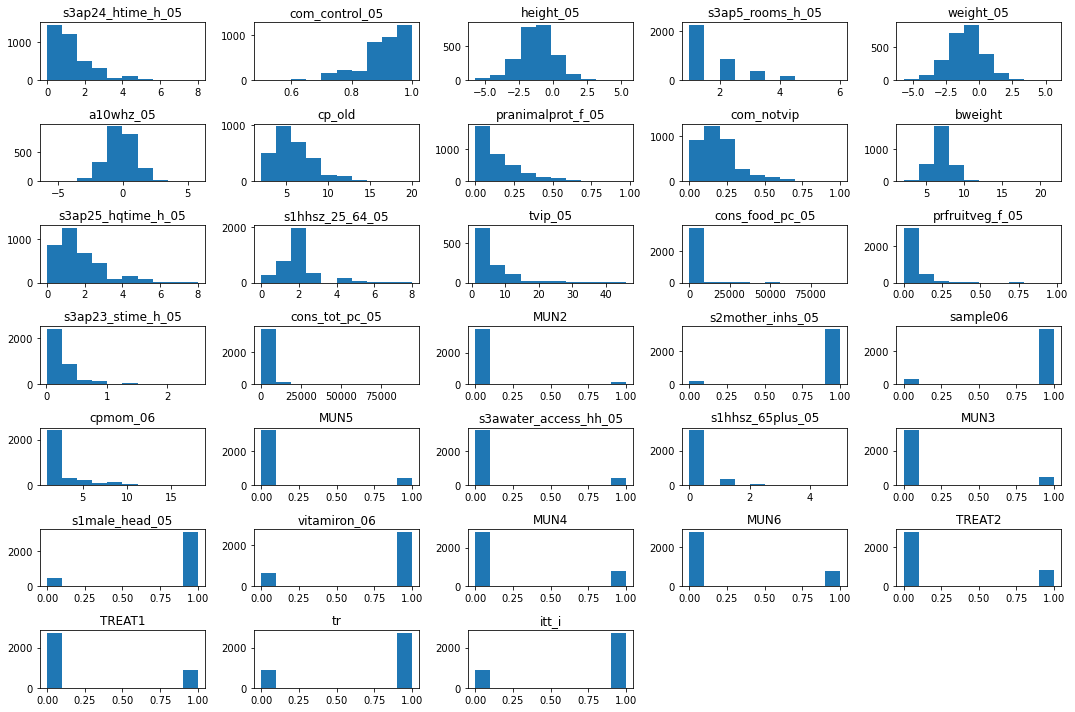

In [48]:
plt.figure(figsize=(15,10))
for col,i in zip(outliers.index,range(len(outliers))):
    plt.subplot(7,5,i+1)
    plt.hist(df[col])
    plt.title(col)
plt.tight_layout()

In [53]:
outlier_cols=['s3ap24_htime_h_05', 'com_control_05', 'height_05',
       'weight_05', 'a10whz_05', 'pranimalprot_f_05', 'com_notvip',
       'bweight', 's3ap25_hqtime_h_05', 's1hhsz_25_64_05', 'tvip_05',
       'cons_food_pc_05', 'prfruitveg_f_05', 's3ap23_stime_h_05',
       'cons_tot_pc_05']

In [59]:
prova=(df1.pipe(copy_df)
            .pipe(drop_ind_missing, 0.8)
            .pipe(drop_out_missing)
            .pipe(ordinal, categorical_cols))
df=prova
outlier_threshold = []
cols=outlier_cols
for col in cols:
    q3 = np.nanpercentile(df[col], 75)
    q1 = np.nanpercentile(df[col], 25)
    iqr = q3 - q1
    out_low = q1 - 3*iqr
    out_high = q3 + 3*iqr
    outlier_threshold.append([out_low, out_high])
outliers_indexs=[]

series_values=[]
for col,k in zip(cols,range(len(cols))):
    outliers_indexs_in_col=[]
    for i in df[col].index:
        if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
            outliers_indexs.append(i)
            outliers_indexs_in_col.append(i)
    #outliers_indexs.append(outliers_indexs_in_col)
    series_values.append(len(outliers_indexs_in_col))

outliers=pd.Series(series_values,index=cols)

In [60]:
outliers[outliers!=[0]*len(outliers)].sort_values()

s3ap24_htime_h_05      2
com_control_05         3
height_05              3
weight_05              4
a10whz_05              5
pranimalprot_f_05      8
com_notvip            14
bweight               29
s3ap25_hqtime_h_05    30
s1hhsz_25_64_05       35
tvip_05               38
cons_food_pc_05       48
prfruitveg_f_05       49
s3ap23_stime_h_05     60
cons_tot_pc_05        60
dtype: int64

In [61]:
len(set(outliers_indexs))

343